# Deep Learning Fundamentals 8: Into the World of Tensorflow/Keras 2

In notebooks 4-6 we built the theoretical background for initialization, normalization, optimization, and regularization. Then in notebook 8, we briefly saw how to use these techniques with Tensorflow and Keras. Now in this notebook, we will have some simple exercises in which we use these techniques.

# Binary Classification with Australian Rain Dataset

In the code below, I will use Binary Classification for Australian Rain Dataset. I will construct a model with classical dropout regularization and train it for 25 epochs.

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("datasets/weatherAUS.csv")
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [4]:
categorical = [features for features in data.columns if data[features].dtype==object]
numerical = [features for features in data.columns if data[features].dtype==float]

In [5]:
data.drop(['WindGustDir','WindDir9am','WindDir3pm'],axis=1,inplace=True)

In [6]:
def splitdate(data_s):
    data_s["Date"] = pd.to_datetime(data_s["Date"]) #convert it to date
    data_s["Year"]=data_s["Date"].dt.year # Parsing year 
    data_s["Month"]=data_s["Date"].dt.month # Parsing month
    data_s["Day"]=data_s["Date"].dt.day # Parsing day
    data_s =  data_s.drop(["Date"], axis=1) # Dropping original Date row
    return data_s;

In [7]:
class Convert_Missing(BaseEstimator, TransformerMixin):
    def __init__(self,data): # no *args or **kargs
        print("Transforming in progress...")
        self.data=data;
        self.splitted_data=splitdate(data);
        self.categorical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==object]
        self.numerical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==float]
        self.numerical_int64 = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype=='int64']
    def transform(self):
        imputer = SimpleImputer(strategy="most_frequent")
        features_categorical=imputer.fit_transform(self.splitted_data[self.categorical])
        imputer = SimpleImputer(strategy="median")
        features_numeric=imputer.fit_transform(self.splitted_data[self.numerical])
        concatenated_array=np.concatenate((features_categorical,features_numeric),axis=1)#concatane arrays obtained from imputer
        dataframe=pd.DataFrame(concatenated_array, columns=self.categorical+self.numerical) # convert it to dataframe
        frames = [dataframe, data[self.numerical_int64]] # combining the dataframe in the previous line and date dataframe 
        final_dataframe=pd.concat(frames,axis=1)  # concataneting the two dataframes in the previous line
        final_dataframe=final_dataframe.loc[:,~final_dataframe.columns.duplicated()]
        print("Transforming completed")
        return final_dataframe

In [8]:
le=LabelEncoder()
def One_Hot_Encoder(data):
    numerical = [features for features in data.columns if data[features].dtype==float]  # getting names of numerical columns
    categorical = [features for features in data.columns if data[features].dtype==object] # getting names of categorical columns
    numerical_int64 = [features for features in data.columns if data[features].dtype=='int64']
    data=pd.concat([data[numerical],data[categorical],data[numerical_int64],pd.get_dummies(data.Location)],axis=1)
    data["RainToday"]=le.fit_transform(data["RainToday"])
    data.drop(['Location'],axis=1,inplace=True)
    return data;

In [9]:
def scaleandmerge(data): 
    scaler = MinMaxScaler()
    numerical_data = scaler.fit_transform(data[numerical])
    numerical_data = pd.DataFrame(numerical_data)
    data.drop(numerical,axis=1,inplace=True)
    data_processed=pd.concat([numerical_data, data],axis=1) 
    return data_processed

In [10]:
def combinedprocessing(data):
    missing_transformer=Convert_Missing(data)
    data1=missing_transformer.transform()
    data2=One_Hot_Encoder(data1)
    data3=scaleandmerge(data2)
    return data3;

In [11]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [12]:
numerical = [features for features in data.columns if data[features].dtype==float]
data_processed=combinedprocessing(data)
data_processed=df_column_uniquify(data_processed)

Transforming in progress...
Transforming completed


Now I will encode the target feature and use `train_test_split()`

In [13]:
le=LabelEncoder()
target=le.fit_transform(data_processed["RainTomorrow"])
data_processed.drop(["RainTomorrow"],axis=1,inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(data_processed, target, test_size = 0.2, random_state = 42)

## Training the Model

In [14]:
y_train = np.asarray(y_train).astype("float64")
y_valid = np.asarray(y_valid).astype("float64")
X_train=np.asarray(X_train).astype("float64")
X_valid=np.asarray(X_valid).astype("float64")

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dropout(rate=0.15),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="selu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.15),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="selu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.15),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_valid, y_valid))

In [16]:
import seaborn as sns
sns.set_theme()

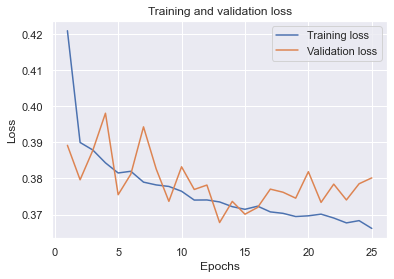

In [17]:
history_dict = history.history
loss_hist = history_dict["loss"]
vallloss_hist = history_dict["val_loss"]
epochs = range(1, len(loss_hist) + 1)
plt.plot(epochs, loss_hist, label="Training loss")
plt.plot(epochs, vallloss_hist, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

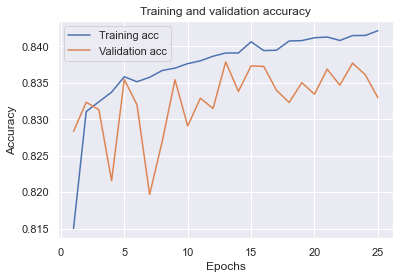

In [18]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Movie Review Classification

Now I will go on with an example from [Chollet, F. (2021).](https://www.manning.com/books/deep-learning-with-python-second-edition).

Firstly, I will load the dataset and I will use `vectorize_sequences()` for converting our predictors into a bag-of-words form. I was thinking of loading this data from a CSV file and using `CountVectorizer()` on the data for converting it to a-bag-of-words format. However, then I thought It would be better to do that in NLP notebooks. Moreover, in the example below only the most common 10000 words are used for classification.

In [19]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\gorke\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\gorke\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

In [20]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

The `vectorize_sequences()` function will convert our data into a bag-of-words shape. In the bag-of-words approach, each word represents a particular word in our dictionary and the ordering of words doesn't matter. I will talk about bag-of-words more in my NLP notes. See the articles about bag-of-words if you'd like to learn more: [A Gentle Introduction to the Bag-of-Words Model](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) and [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [21]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [22]:
x_train[1]

array([0., 1., 1., ..., 0., 0., 0.])

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dropout(rate=0.15),
    layers.Dense(32, activation="selu"),
    layers.Dropout(rate=0.15),
    layers.Dense(16, activation="selu"),
    layers.Dropout(rate=0.15),
    layers.Dense(1, activation="sigmoid")
])

In [24]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

Instead of creating a validation set, I will directly use the test set for validation. This is because I don't think It is important to create a validation set for this simple example.

In [ ]:
history = model.fit(x_train, y_test, epochs=20, batch_size=256, validation_data=(x_test, y_test))

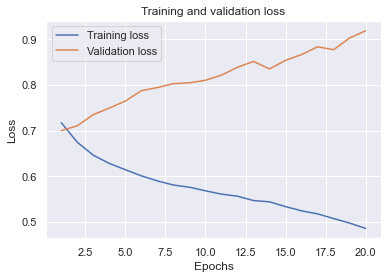

In [26]:
history_dict = history.history
loss_hist = history_dict["loss"]
vallloss_hist = history_dict["val_loss"]
epochs = range(1, len(loss_hist) + 1)
plt.plot(epochs, loss_hist, label="Training loss")
plt.plot(epochs, vallloss_hist, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

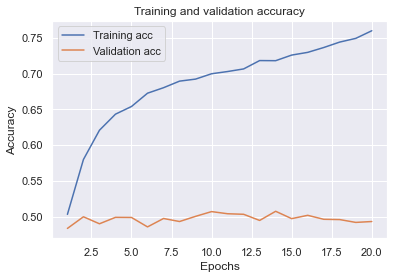

In [27]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

I slightly altered the neural net to see if perhaps I could improve the model a bit, however, it looks like It didn't work out. In this situation, It would be logical to train the model up to 4 epochs which gives the best result according to the two plots above. I will improve the results for this dataset later with different neural networks.

## Multiclass Classification Reuters The Wire News

This example is also taken from [Chollet, F. (2021).](https://www.manning.com/books/deep-learning-with-python-second-edition).

In [28]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

C:\Users\gorke\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\gorke\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Let's encode the predictors and labels.

In [29]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [30]:
def to_one_hot(labels, dimension=46): # for encoding labels
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [31]:
model = keras.Sequential([
    layers.Dropout(rate=0.4),
    layers.Dense(128, activation="selu",kernel_initializer="he_normal"),
    layers.Dropout(rate=0.4),
    layers.Dense(64, activation="selu",kernel_initializer="he_normal"),
    layers.Dropout(rate=0.4),
    layers.Dense(46, activation="softmax",kernel_initializer="he_normal")
])

In [32]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

This time I will use a validation set.

In [33]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val))

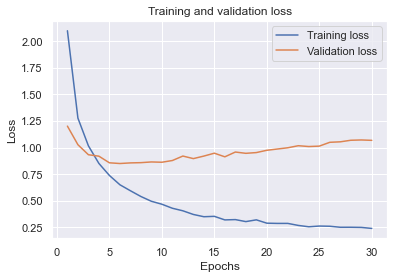

In [35]:
history_dict = history.history
loss_hist = history_dict["loss"]
vallloss_hist = history_dict["val_loss"]
epochs = range(1, len(loss_hist) + 1)
plt.plot(epochs, loss_hist, label="Training loss")
plt.plot(epochs, vallloss_hist, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

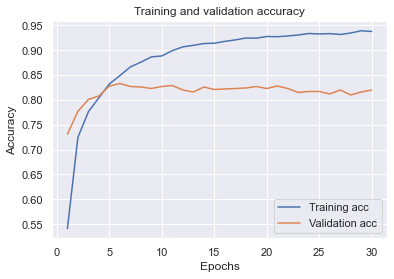

In [36]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It looks like we can train the model up to the 8-9th epoch and get the best result.

I would like to also mention that we can alternatively encode the labels as integer tensors. 

In [37]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

Since the labels are not categorical anymore, we can use sparse_categorical_crossentropy. 

In [38]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val))


# Boston Housing Regregression with Monte Carlo Dropout


An interesting question that came to my mind after learning about Monter Carlo Dropout is whether we can use it for regression. I firstly thought we could not use it with regression but then I thought we could use it. I searched about it on Google and it turns out that we can use MC Dropout with regression tasks. Let's have a quick example.

In [40]:
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.boston_housing.load_data(
      path="boston_housing.npz")

In [41]:
model = keras.models.Sequential([
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(lr=0.001))
history = model.fit(X_train, y_train, epochs=50 ,validation_split=0.1)

In [43]:
from sklearn.metrics import mean_squared_error
y_pred2=model.predict(X_test)
mean_squared_error(y_pred2,y_test)

77.49437249808527

Now It comes to the interesting part. As we did in the Monte Carlo Dropout example of the previous notebook, we will stack the predictions of different neural networks and get the mean of predictions. For implementing MC Dropout Regression, I will use the code taken from one of the articles that I shared previously [link](https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571). 

In [44]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

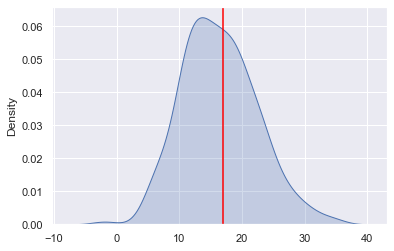

In [45]:
y_pred_dist = predict_dist(X_test, model, 250)
y_pred = predict_point(X_test, model, 250)

sns.kdeplot(y_pred_dist[0], shade=True)
plt.axvline(y_pred[0], color='red')
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred,y_test)

58.00175107297188

Looks like Monte Carlo Dropout improved the result.

Let's also add batch normalization. Notice that this time, we need to force training.

In [47]:
model = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[13,]),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(lr=0.001))
history = model.fit(X_train, y_train, epochs=50 ,validation_split=0.1)

In [49]:
y_pred2=model.predict(X_test)
mean_squared_error(y_pred2,y_test)

25.066602161169506

In [50]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


In [51]:
mc_model = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
    for layer in model.layers
])

In [52]:
mc_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 13)                52        
_________________________________________________________________
mc_dropout (MCDropout)       (None, 13)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

In [ ]:
mc_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(lr=0.001))
history = mc_model.fit(X_train, y_train, epochs=50 ,validation_split=0.1)

In [54]:
y_pred = np.round(np.mean([mc_model.predict(X_test) for sample in range(250)], axis=0), 3)

In [55]:
mean_squared_error(y_pred,y_test)

16.912154834871632

# Some Interesting Cases of Deep Learning Model

## 1. Spurious Correlations: 
Spurious Correlations are important factors that can affect training performance. One can generally come across spurious correlations in two cases.

The first one is when we have an instance that appears very rare in our data. For instance, in a sentiment classification task, there is a word that only appears twice (it appears in two texts) and these texts are associated with negative sentiments. If the model is poorly regularized, it might put a very high weight on this word and classify new texts that contain the word as negative, whereas, the texts may be positive.

Spurious correlation can be also caused by statistical fluke. For instance, let's say we have an instance that occurs 100 times in our training data and it is associated with a positive sentiment %60 times and with a negative sentiment %40 of the time. However, this occurrence may be completely caused by a statistical fluke, but the model is likely to learn to leverage that feature.

Let's see an example of how spurious correlation can affect model performance. We will add some noise to MNIST data and see how it will affect the performance.

Let's add the white noise or zero channels to MNIST

In [56]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

Let's train the model now and see the difference.

In [57]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 8s 20ms/step - loss: 0.6205 - accuracy: 0.8124 - val_loss: 0.3208 - val_accuracy: 0.9026
Epoch 2/10
375/375 [==============================] - 7s 18ms/step - loss: 0.2474 - accuracy: 0.9237 - val_loss: 0.2063 - val_accuracy: 0.9377
Epoch 3/10
375/375 [==============================] - 7s 18ms/step - loss: 0.1610 - accuracy: 0.9504 - val_loss: 0.1706 - val_accuracy: 0.9475
Epoch 4/10
375/375 [==============================] - 7s 20ms/step - loss: 0.1141 - accuracy: 0.9650 - val_loss: 0.1529 - val_accuracy: 0.9553
Epoch 5/10
375/375 [==============================] - 6s 17ms/step - loss: 0.0840 - accuracy: 0.9733 - val_loss: 0.1276 - val_accuracy: 0.9643
Epoch 6/10
375/375 [==============================] - 7s 18ms/step - loss: 0.0607 - accuracy: 0.9815 - val_loss: 0.1265 - val_accuracy: 0.9635
Epoch 7/10
375/375 [==============================] - 6s 17ms/step - loss: 0.0472 - accuracy: 0.9850 - val_loss: 0.2154 - val_accuracy: 0.9386

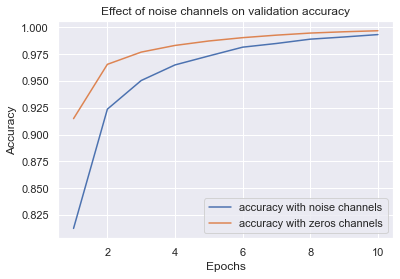

In [58]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["accuracy"]
val_acc_zeros = history_zeros.history["accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise,
         label="accuracy with noise channels")
plt.plot(epochs, val_acc_zeros,
         label="accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

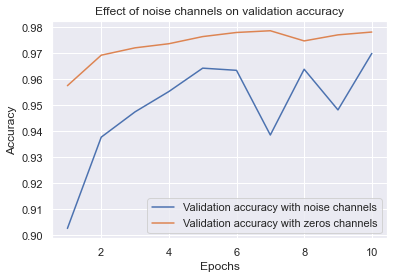

In [59]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise,
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros,
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Okay, now we need to take some notes here.

We trained two models on two different MNIST data here. The first model was trained on the MNIST dataset that has noise and this noise caused spurious correlations which affected the validation accuracy. Even though the training accuracy scores are very close, the noise led to overfitting and reduced the performance of the model. For comparison, the second model was trained on the MNIST dataset with a zeros channel, this version of data didn't affect the model because we didn't change anything with the information content of the data. The takeaway note is that feature selection is important.

## 2. The nature of generalization in deep learning

I directly took the headline from the book [Chollet, F. (2021).](https://www.manning.com/books/deep-learning-with-python-second-edition) because this example was very striking to me. I didn't actually think that would work before and I was really surprised. In the book it is said that

* A remarkable fact about deep learning models is that they can be trained to fit anything, as long as they have enough representational power. - [Chollet, F. (2021).](https://www.manning.com/books/deep-learning-with-python-second-edition)

Well, let's shuffle the MNIST data and train a model on that shuffled version.

In [ ]:
(train_images, train_labels), _ = keras.datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=256,
          validation_split=0.2)

Even though there is no correlation relationship between the inputs and the shuffled labels, the model performs pretty well. However, this is not the same for validation. The reason that validation doesn't improve is that since we shuffle the data there is no possibility of generalization. However, it somehow feels still strange to me the training accuracy increases that much.

# Manifold Learning

I would like to end this notebook with one of the topics in the books [Géron, A. (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and [Chollet, F. (2021).](https://www.manning.com/books/deep-learning-with-python-second-edition) that caught my attention a lot (In fact, manifold learning is also one of the areas that I work on, and whenever I read anything about it I get so interested).

**Note:** I directly took the section below from the books mentioned above.

* The manifold hypothesis posits that all natural data lies on a low-dimensional manifold within the high-dimensional space where it is encoded. That’s a pretty strong statement about the structure of information in the universe. As far as we know, it’s accurate, and it’s the reason why deep learning works. It’s true for MNIST digits, but also for human faces, tree morphology, the sounds of the human voice, and even natural language.


The manifold hypothesis implies that
* Machine learning models only have to fit relatively simple, low-dimensional,
highly structured subspaces within their potential input space (latent manifolds).
* Within one of these manifolds, it’s always possible to interpolate between two inputs, that is to say, morph one into another via a continuous path along which all points fall on the manifold.
* Deep learning models implement a smooth, continuous mapping from their inputs to their outputs. It has to be smooth and continuous because it must be differentiable, by necessity (you couldn’t do gradient descent otherwise). This smoothness helps approximate latent manifolds, which follow the same properties.
* Deep learning models tend to be structured in a way that mirrors the “shape” of the information in their training data (via architecture priors). More generally, deep neural networks structure their learned representations in a hierarchical and modular way, which echoes the way natural data is organized.


The ability to interpolate between samples is the key to understanding generalization in deep learning.


While deep learning is indeed well suited to manifold learning, the power to generalize is more a consequence of the natural structure of your data than a consequence of any property of your model. You’ll only be able to generalize if your data forms a manifold where points can be interpolated. The more informative and the less noisy your features are, the better you will be able to generalize, since your input space will be simpler and better structured. Data curation and feature engineering are essential to generalization.

Fortunately, modern deep learning removes the need for most feature engineering, because neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:
* Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
* Good features let you solve a problem with far fewer data. The ability of deep learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, the information value in their features becomes critical.